Sample HML Returns (last 10 observations):
date
2017-09-30    0.019246
2017-10-31    0.018413
2017-11-30    0.008589
2017-12-31    0.006695
2018-01-31   -0.021847
2018-02-28   -0.001459
2018-03-31    0.018048
2018-04-30    0.011210
2018-05-31   -0.026929
2018-06-30   -0.007917
Name: long_short_return, dtype: float64

Historical Statistics:
Mean: 0.0040
Std: 0.0249
Sharpe Ratio: 0.5624

Estimated Parameters:
Annual Drift (μ): 0.0447
Annual Volatility (σ): 0.0860

Running Monte Carlo simulation...

Confidence Intervals for Final Period:
5th_percentile      89.277131
25th_percentile    107.655078
50th_percentile    122.443293
75th_percentile    139.625039
95th_percentile    167.722516
period              60.000000
Name: 60, dtype: float64

Summary Statistics for Final Values:
mean: 124.8527
median: 122.4433
std: 24.4413
min: 56.0007
max: 265.9956
skewness: 0.6109
kurtosis: 0.7974
prob_positive: 85.45%
var_95: 89.2771
var_99: 77.8631


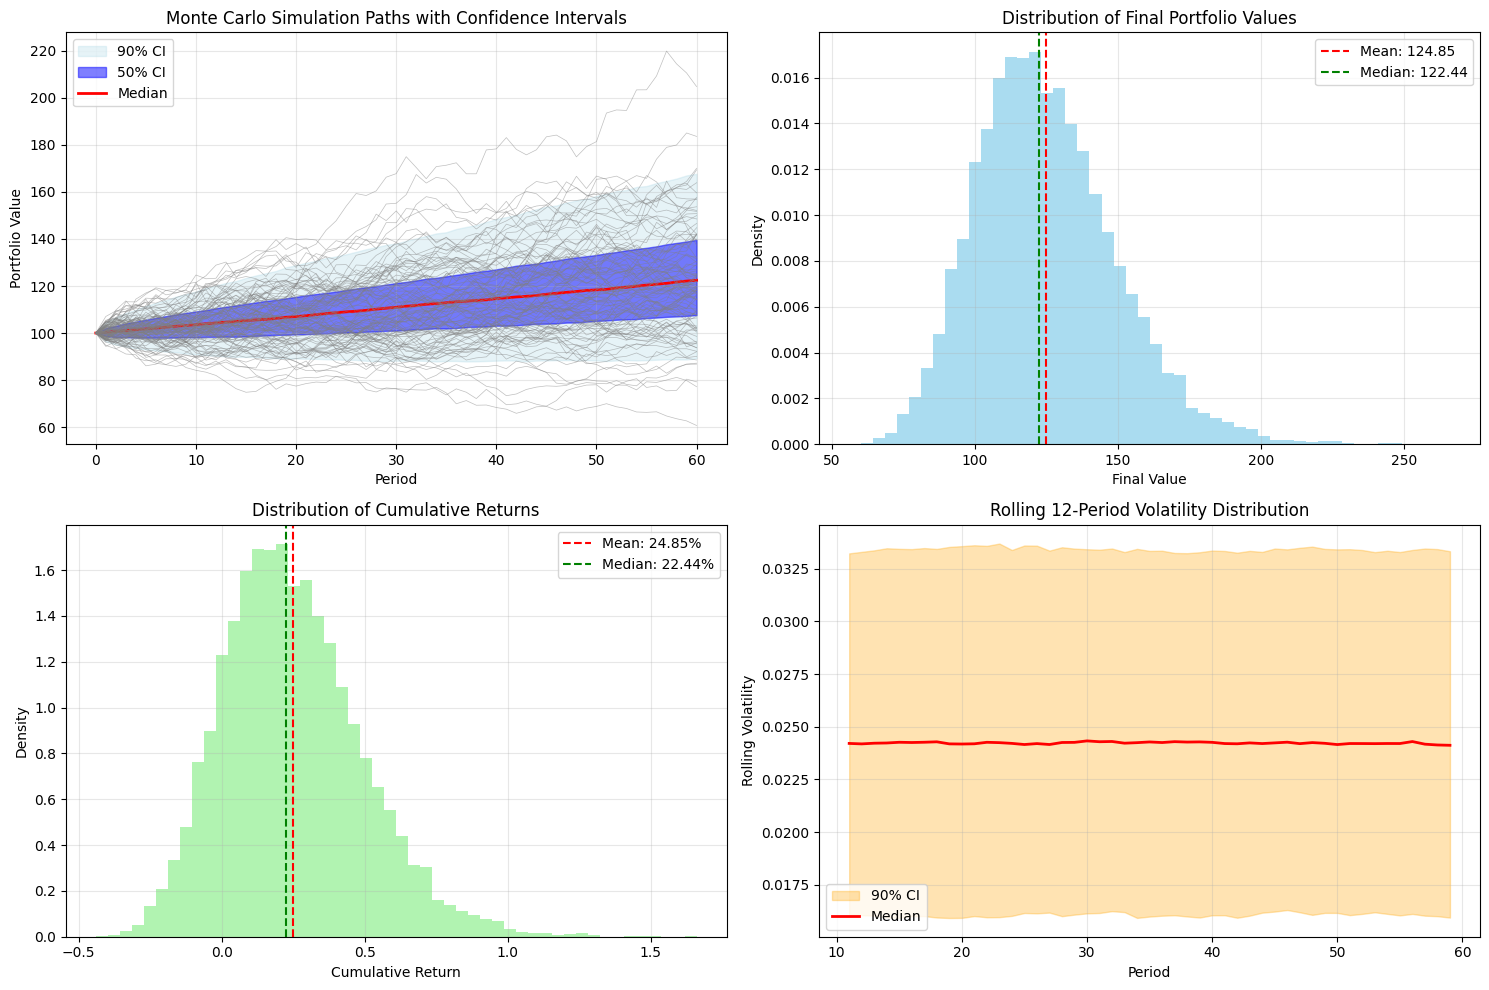

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class HMLMonteCarloGBM:
    """
    Monte Carlo simulation using Geometric Brownian Motion for HML portfolio returns
    """
    
    def __init__(self, returns_data):
        """
        Initialize with historical returns data
        
        Parameters:
        returns_data: pandas Series or numpy array of historical returns
        """
        self.returns = np.array(returns_data)
        self.mu = None
        self.sigma = None
        
    def estimate_parameters(self, annualize=True, periods_per_year=12):
        """
        Estimate drift (mu) and volatility (sigma) from historical data
        
        Parameters:
        annualize: bool, whether to annualize the parameters
        periods_per_year: int, number of periods per year (12 for monthly, 252 for daily)
        """
        # Calculate log returns if input is price levels
        if np.all(self.returns > 0):  # Assuming these are prices, not returns
            log_returns = np.log(self.returns[1:] / self.returns[:-1])
        else:  # Assuming these are already returns
            log_returns = np.log(1 + self.returns)
        
        # Estimate parameters
        self.mu = np.mean(log_returns)
        self.sigma = np.std(log_returns, ddof=1)
        
        if annualize:
            self.mu *= periods_per_year
            self.sigma *= np.sqrt(periods_per_year)
            
        return self.mu, self.sigma
    
    def simulate_paths(self, n_simulations=10000, n_periods=60, dt=1/12, 
                      initial_value=100, seed=42):
        """
        Run Monte Carlo simulation using GBM
        
        Parameters:
        n_simulations: int, number of simulation paths
        n_periods: int, number of periods to simulate
        dt: float, time step (1/12 for monthly if annualized)
        initial_value: float, starting portfolio value
        seed: int, random seed for reproducibility
        
        Returns:
        numpy array of shape (n_simulations, n_periods+1) with simulated paths
        """
        if self.mu is None or self.sigma is None:
            raise ValueError("Parameters not estimated. Run estimate_parameters() first.")
        
        np.random.seed(seed)
        
        # Pre-allocate array for efficiency
        paths = np.zeros((n_simulations, n_periods + 1))
        paths[:, 0] = initial_value
        
        # Generate random shocks
        dW = np.random.normal(0, np.sqrt(dt), (n_simulations, n_periods))
        
        # Simulate paths using vectorized operations
        for t in range(n_periods):
            paths[:, t + 1] = paths[:, t] * np.exp(
                (self.mu - 0.5 * self.sigma**2) * dt + self.sigma * dW[:, t]
            )
        
        self.paths = paths
        return paths
    
    def calculate_returns(self):
        """Calculate period returns from simulated paths"""
        if not hasattr(self, 'paths'):
            raise ValueError("No simulation paths found. Run simulate_paths() first.")
        
        returns = (self.paths[:, 1:] / self.paths[:, :-1]) - 1
        return returns
    
    def get_confidence_intervals(self, confidence_levels=[0.05, 0.25, 0.5, 0.75, 0.95]):
        """
        Calculate confidence intervals for simulated paths
        
        Parameters:
        confidence_levels: list of confidence levels (as decimals)
        
        Returns:
        DataFrame with confidence intervals over time
        """
        if not hasattr(self, 'paths'):
            raise ValueError("No simulation paths found. Run simulate_paths() first.")
        
        percentiles = np.percentile(self.paths, [p*100 for p in confidence_levels], axis=0)
        
        ci_df = pd.DataFrame(percentiles.T, 
                           columns=[f'{int(p*100)}th_percentile' for p in confidence_levels])
        ci_df['period'] = range(len(ci_df))
        
        return ci_df
    
    def get_summary_statistics(self):
        """Get summary statistics for the final period values"""
        if not hasattr(self, 'paths'):
            raise ValueError("No simulation paths found. Run simulate_paths() first.")
        
        final_values = self.paths[:, -1]
        
        stats_dict = {
            'mean': np.mean(final_values),
            'median': np.median(final_values),
            'std': np.std(final_values),
            'min': np.min(final_values),
            'max': np.max(final_values),
            'skewness': stats.skew(final_values),
            'kurtosis': stats.kurtosis(final_values),
            'prob_positive': np.mean(final_values > self.paths[0, 0]),
            'var_95': np.percentile(final_values, 5),
            'var_99': np.percentile(final_values, 1)
        }
        
        return stats_dict
    
    def plot_simulation_results(self, n_paths_to_plot=100, figsize=(15, 10)):
        """
        Plot simulation results with confidence intervals
        
        Parameters:
        n_paths_to_plot: int, number of individual paths to show
        figsize: tuple, figure size
        """
        if not hasattr(self, 'paths'):
            raise ValueError("No simulation paths found. Run simulate_paths() first.")
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot 1: Sample paths with confidence intervals
        ci_df = self.get_confidence_intervals()
        time_axis = range(len(ci_df))
        
        axes[0, 0].fill_between(time_axis, ci_df['5th_percentile'], ci_df['95th_percentile'], 
                               alpha=0.3, color='lightblue', label='90% CI')
        axes[0, 0].fill_between(time_axis, ci_df['25th_percentile'], ci_df['75th_percentile'], 
                               alpha=0.5, color='blue', label='50% CI')
        axes[0, 0].plot(time_axis, ci_df['50th_percentile'], 'r-', linewidth=2, label='Median')
        
        # Plot sample paths
        sample_indices = np.random.choice(len(self.paths), n_paths_to_plot, replace=False)
        for i in sample_indices:
            axes[0, 0].plot(time_axis, self.paths[i], alpha=0.5, color='gray', linewidth=0.5)
        
        axes[0, 0].set_title('Monte Carlo Simulation Paths with Confidence Intervals')
        axes[0, 0].set_xlabel('Period')
        axes[0, 0].set_ylabel('Portfolio Value')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Distribution of final values
        final_values = self.paths[:, -1]
        axes[0, 1].hist(final_values, bins=50, density=True, alpha=0.7, color='skyblue')
        axes[0, 1].axvline(np.mean(final_values), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(final_values):.2f}')
        axes[0, 1].axvline(np.median(final_values), color='green', linestyle='--', 
                          label=f'Median: {np.median(final_values):.2f}')
        axes[0, 1].set_title('Distribution of Final Portfolio Values')
        axes[0, 1].set_xlabel('Final Value')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Cumulative returns distribution
        cumulative_returns = (self.paths[:, -1] / self.paths[:, 0]) - 1
        axes[1, 0].hist(cumulative_returns, bins=50, density=True, alpha=0.7, color='lightgreen')
        axes[1, 0].axvline(np.mean(cumulative_returns), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(cumulative_returns):.2%}')
        axes[1, 0].axvline(np.median(cumulative_returns), color='green', linestyle='--', 
                          label=f'Median: {np.median(cumulative_returns):.2%}')
        axes[1, 0].set_title('Distribution of Cumulative Returns')
        axes[1, 0].set_xlabel('Cumulative Return')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Rolling volatility of paths
        returns = self.calculate_returns()
        rolling_vol = pd.DataFrame(returns.T).rolling(window=12).std().values.T
        vol_percentiles = np.percentile(rolling_vol, [5, 25, 50, 75, 95], axis=0)
        
        time_axis_vol = range(len(vol_percentiles[0]))
        axes[1, 1].fill_between(time_axis_vol, vol_percentiles[0], vol_percentiles[4], 
                               alpha=0.3, color='orange', label='90% CI')
        axes[1, 1].plot(time_axis_vol, vol_percentiles[2], 'r-', linewidth=2, label='Median')
        axes[1, 1].set_title('Rolling 12-Period Volatility Distribution')
        axes[1, 1].set_xlabel('Period')
        axes[1, 1].set_ylabel('Rolling Volatility')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Example usage with synthetic HML data
def generate_sample_hml_data(n_periods=120, seed=123):
    """Generate sample HML returns for demonstration"""
    np.random.seed(seed)
    
    # Simulate HML-like returns with some realistic characteristics
    # Lower returns post-2007, higher volatility
    pre_crisis = np.random.normal(0.008, 0.04, 60)  # Higher mean return
    post_crisis = np.random.normal(0.002, 0.05, 60)  # Lower mean, higher vol
    
    hml_returns = np.concatenate([pre_crisis, post_crisis])
    dates = pd.date_range('2000-01-01', periods=n_periods, freq='M')
    
    return pd.Series(hml_returns, index=dates)

# Example implementation
if __name__ == "__main__":
    # Generate sample data (replace with your actual HML returns)
    hml_returns = pd.read_csv('Data/long_short_returns_clean.csv', index_col='date')['long_short_return']
    
    print("Sample HML Returns (last 10 observations):")
    print(hml_returns.tail(10))
    print(f"\nHistorical Statistics:")
    print(f"Mean: {hml_returns.mean():.4f}")
    print(f"Std: {hml_returns.std():.4f}")
    print(f"Sharpe Ratio: {hml_returns.mean()/hml_returns.std()*np.sqrt(12):.4f}")
    
    # Initialize Monte Carlo simulation
    mc_sim = HMLMonteCarloGBM(hml_returns)
    
    # Estimate parameters from historical data
    mu, sigma = mc_sim.estimate_parameters(annualize=True, periods_per_year=12)
    print(f"\nEstimated Parameters:")
    print(f"Annual Drift (μ): {mu:.4f}")
    print(f"Annual Volatility (σ): {sigma:.4f}")
    
    # Run simulation
    print(f"\nRunning Monte Carlo simulation...")
    paths = mc_sim.simulate_paths(n_simulations=10000, n_periods=60, 
                                 initial_value=100, seed=42)
    
    # Get confidence intervals
    ci_df = mc_sim.get_confidence_intervals()
    print(f"\nConfidence Intervals for Final Period:")
    print(ci_df.iloc[-1])
    
    # Get summary statistics
    summary_stats = mc_sim.get_summary_statistics()
    print(f"\nSummary Statistics for Final Values:")
    for key, value in summary_stats.items():
        if 'prob' in key:
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.4f}")
    
    # Plot results
    mc_sim.plot_simulation_results()

Sample HML Returns (last 10 observations):
date
2017-09-30    0.007324
2017-10-31    0.010605
2017-11-30    0.013697
2017-12-31    0.020152
2018-01-31   -0.018542
2018-02-28   -0.008893
2018-03-31    0.006576
2018-04-30    0.012575
2018-05-31   -0.031393
2018-06-30   -0.017673
Name: hml_return, dtype: float64

Historical Statistics:
Mean: 0.0035
Std: 0.0244
Sharpe Ratio: 0.4912

Ornstein-Uhlenbeck Parameters:
Mean Reversion Speed (θ): 0.8087
Long-term Mean (μ): 0.0035
Half-life: 0.86 periods

GARCH(1,1) Parameters:
ω (omega): 0.000020
α (alpha): 0.1066
β (beta): 0.8527
Persistence (α+β): 0.9593

Running OU-GARCH Monte Carlo simulation...

Confidence Intervals for Final Period (Portfolio Value):
5th_percentile      41.635367
25th_percentile     70.799799
50th_percentile     93.604938
75th_percentile    121.503154
95th_percentile    190.021412
period              60.000000
Name: 60, dtype: float64

Summary Statistics for Final Values:
mean: 102.9428
median: 93.6049
std: 58.5645
min: 0.18

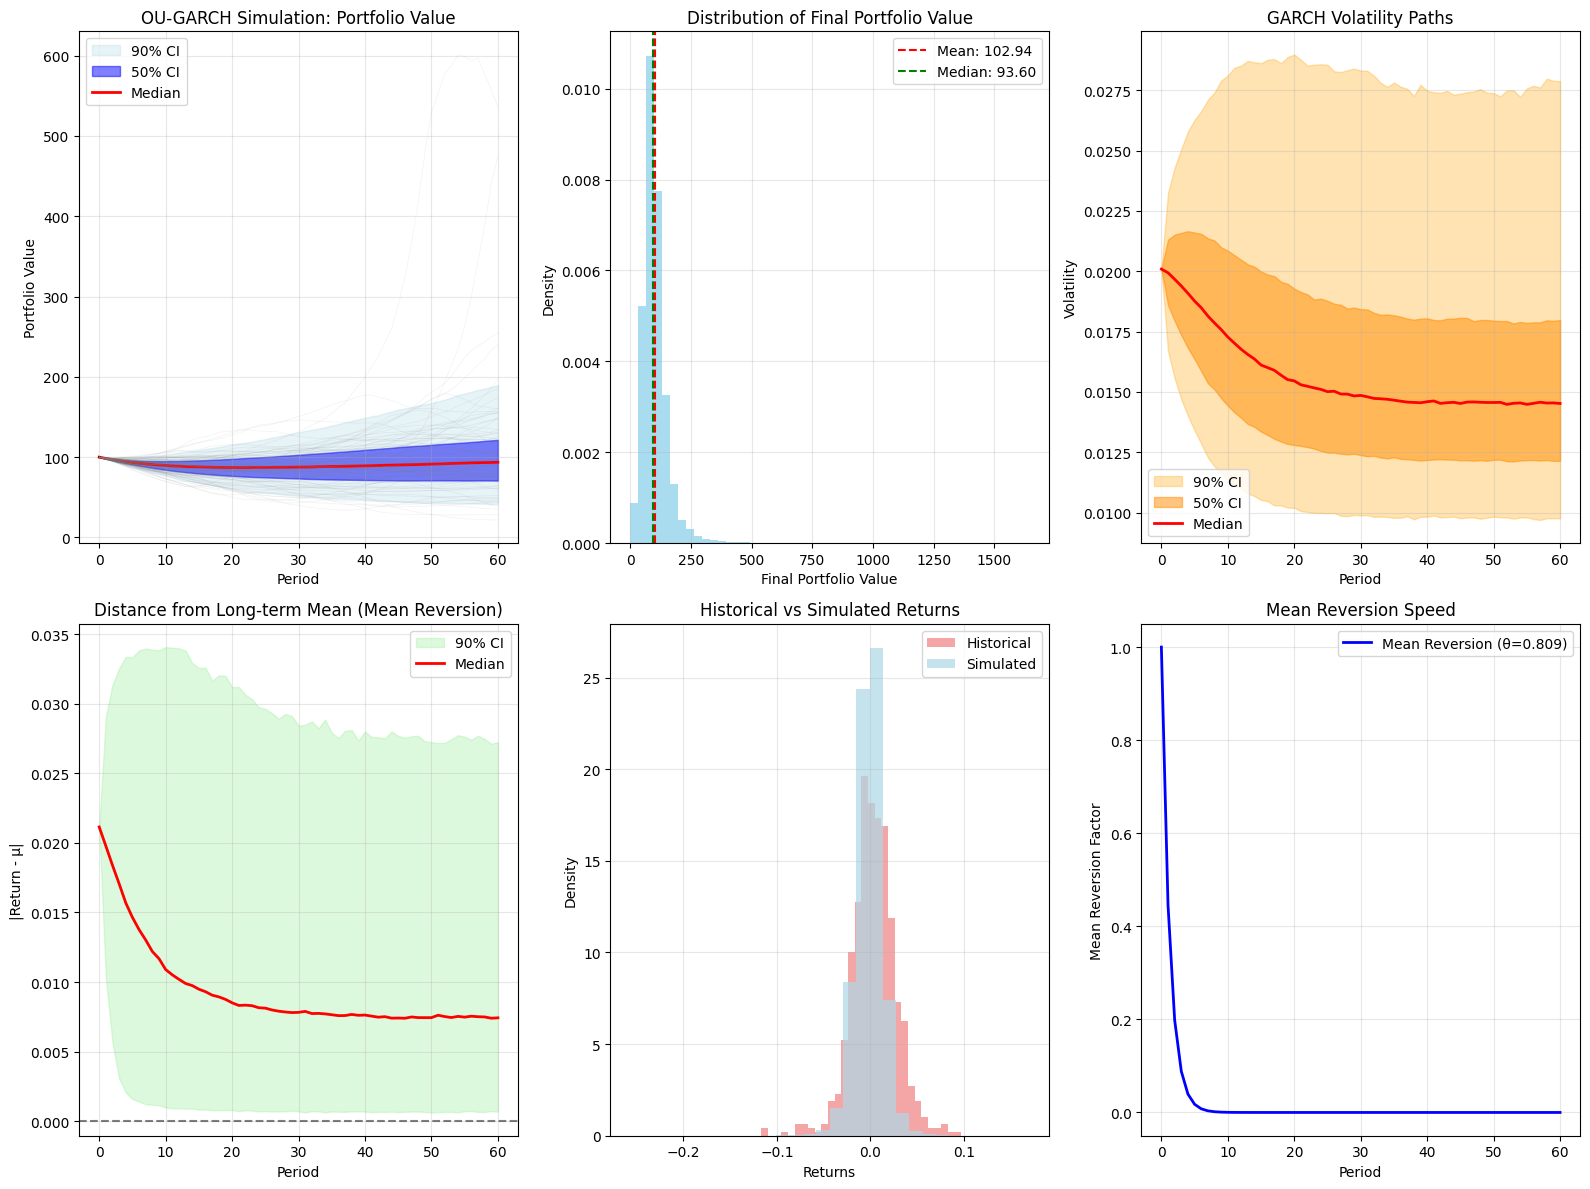

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

class HMLMonteCarloOUGARCH:
    """
    Monte Carlo simulation using Ornstein-Uhlenbeck process with GARCH volatility for HML portfolio returns
    """
    
    def __init__(self, returns_data):
        """
        Initialize with historical returns data
        
        Parameters:
        returns_data: pandas Series or numpy array of historical returns
        """
        self.returns = np.array(returns_data)
        self.theta = None  # Mean reversion speed
        self.mu = None     # Long-term mean
        self.garch_params = None  # GARCH parameters
        self.conditional_volatility = None
        
    def estimate_ou_parameters(self):
        """
        Estimate Ornstein-Uhlenbeck parameters using Maximum Likelihood
        dx = theta * (mu - x) * dt + sigma * dW
        """
        returns = self.returns
        n = len(returns)
        
        def ou_log_likelihood(params):
            theta, mu = params
            if theta <= 0:  # Ensure mean reversion
                return np.inf
            
            # Calculate residuals
            residuals = np.zeros(n-1)
            for i in range(1, n):
                expected = returns[i-1] + theta * (mu - returns[i-1])
                residuals[i-1] = returns[i] - expected
            
            # Log likelihood (assuming constant volatility for OU estimation)
            sigma_ou = np.std(residuals)
            log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma_ou**2) - \
                           0.5 * np.sum(residuals**2) / sigma_ou**2
            
            return -log_likelihood  # Minimize negative log likelihood
        
        # Initial guess
        initial_guess = [0.5, np.mean(returns)]
        
        # Bounds: theta > 0, mu can be any value
        bounds = [(0.01, 5.0), (-1.0, 1.0)]
        
        try:
            result = minimize(ou_log_likelihood, initial_guess, bounds=bounds, method='L-BFGS-B')
            self.theta, self.mu = result.x
        except:
            # Fallback to simple estimation
            self.theta = 0.5
            self.mu = np.mean(returns)
        
        return self.theta, self.mu
    
    def estimate_garch_parameters(self, p=1, q=1):
        """
        Estimate GARCH(p,q) parameters using Maximum Likelihood
        sigma_t^2 = omega + alpha * epsilon_{t-1}^2 + beta * sigma_{t-1}^2
        """
        returns = self.returns
        n = len(returns)
        
        def garch_log_likelihood(params):
            omega, alpha, beta = params
            
            # Parameter constraints
            if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
                return np.inf
            
            # Initialize
            sigma2 = np.var(returns)  # Unconditional variance
            sigma2_series = np.zeros(n)
            sigma2_series[0] = sigma2
            
            log_likelihood = 0
            
            for t in range(1, n):
                # GARCH(1,1) equation
                epsilon_prev = returns[t-1]
                sigma2 = omega + alpha * epsilon_prev**2 + beta * sigma2_series[t-1]
                sigma2_series[t] = sigma2
                
                # Log likelihood contribution
                if sigma2 > 0:
                    log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(sigma2) + 
                                             returns[t]**2 / sigma2)
                else:
                    return np.inf
            
            self.conditional_volatility = np.sqrt(sigma2_series)
            return -log_likelihood
        
        # Initial guess
        initial_guess = [np.var(returns) * 0.1, 0.1, 0.8]
        
        # Bounds
        bounds = [(1e-6, 1.0), (0.0, 1.0), (0.0, 1.0)]
        
        try:
            result = minimize(garch_log_likelihood, initial_guess, bounds=bounds, method='L-BFGS-B')
            omega, alpha, beta = result.x
            self.garch_params = {'omega': omega, 'alpha': alpha, 'beta': beta}
        except:
            # Fallback parameters
            self.garch_params = {'omega': np.var(returns) * 0.1, 'alpha': 0.1, 'beta': 0.8}
            self.conditional_volatility = np.full(len(returns), np.std(returns))
        
        return self.garch_params
    
    def forecast_garch_volatility(self, n_periods):
        """
        Forecast GARCH volatility for future periods
        """
        if self.garch_params is None:
            raise ValueError("GARCH parameters not estimated. Run estimate_garch_parameters() first.")
        
        omega = self.garch_params['omega']
        alpha = self.garch_params['alpha']
        beta = self.garch_params['beta']
        
        # Get last observed values
        last_return = self.returns[-1]
        last_sigma2 = self.conditional_volatility[-1]**2
        
        # Forecast volatility
        forecast_sigma2 = np.zeros(n_periods)
        
        # Unconditional variance for long-term forecast
        uncond_var = omega / (1 - alpha - beta)
        
        for t in range(n_periods):
            if t == 0:
                forecast_sigma2[t] = omega + alpha * last_return**2 + beta * last_sigma2
            else:
                # Forecast converges to unconditional variance
                forecast_sigma2[t] = omega + (alpha + beta) * forecast_sigma2[t-1]
                # Add convergence to unconditional variance
                forecast_sigma2[t] = forecast_sigma2[t] + \
                                   (uncond_var - forecast_sigma2[t]) * (1 - (alpha + beta))
        
        return np.sqrt(forecast_sigma2)
    
    def simulate_ou_garch_paths(self, n_simulations=10000, n_periods=60, dt=1/12, 
                               initial_value=None, seed=42):
        """
        Run Monte Carlo simulation using Ornstein-Uhlenbeck process with GARCH volatility
        
        Parameters:
        n_simulations: int, number of simulation paths
        n_periods: int, number of periods to simulate
        dt: float, time step
        initial_value: float, starting return level (if None, uses last observed return)
        seed: int, random seed for reproducibility
        
        Returns:
        tuple: (paths, volatility_paths) - simulated return paths and volatility paths
        """
        if self.theta is None or self.mu is None:
            raise ValueError("OU parameters not estimated. Run estimate_ou_parameters() first.")
        
        if self.garch_params is None:
            raise ValueError("GARCH parameters not estimated. Run estimate_garch_parameters() first.")
        
        np.random.seed(seed)
        
        # Initialize
        if initial_value is None:
            initial_value = self.returns[-1]
        
        # Pre-allocate arrays
        paths = np.zeros((n_simulations, n_periods + 1))
        volatility_paths = np.zeros((n_simulations, n_periods + 1))
        
        # Set initial values
        paths[:, 0] = initial_value
        
        # Forecast initial volatility path
        base_vol_forecast = self.forecast_garch_volatility(n_periods)
        
        # Simulate paths
        for sim in range(n_simulations):
            # Initialize volatility for this simulation
            volatility_paths[sim, 0] = self.conditional_volatility[-1]
            
            for t in range(n_periods):
                # Current state
                current_return = paths[sim, t]
                current_vol = volatility_paths[sim, t]
                
                # Generate random shock
                dW = np.random.normal(0, np.sqrt(dt))
                
                # Ornstein-Uhlenbeck process
                dr = self.theta * (self.mu - current_return) * dt + current_vol * dW
                paths[sim, t + 1] = current_return + dr
                
                # Update volatility using GARCH structure with some randomness
                omega = self.garch_params['omega']
                alpha = self.garch_params['alpha']
                beta = self.garch_params['beta']
                
                # GARCH volatility update with forecast as base
                new_vol_squared = omega + alpha * (current_return**2) + beta * (current_vol**2)
                
                # Add some randomness around the forecast
                vol_shock = np.random.normal(1, 0.1)  # 10% volatility of volatility
                new_vol_squared *= vol_shock**2
                
                # Ensure positive volatility
                volatility_paths[sim, t + 1] = max(np.sqrt(new_vol_squared), 0.001)
        
        self.paths = paths
        self.volatility_paths = volatility_paths
        
        return paths, volatility_paths
    
    def convert_to_price_paths(self, initial_price=100):
        """Convert return paths to price paths"""
        if not hasattr(self, 'paths'):
            raise ValueError("No simulation paths found. Run simulate_ou_garch_paths() first.")
        
        # Convert returns to cumulative price paths
        price_paths = np.zeros_like(self.paths)
        price_paths[:, 0] = initial_price
        
        for t in range(1, self.paths.shape[1]):
            price_paths[:, t] = price_paths[:, t-1] * (1 + self.paths[:, t])
        
        return price_paths
    
    def get_confidence_intervals(self, confidence_levels=[0.05, 0.25, 0.5, 0.75, 0.95], 
                                use_prices=True, initial_price=100):
        """Calculate confidence intervals for simulated paths"""
        if not hasattr(self, 'paths'):
            raise ValueError("No simulation paths found. Run simulate_ou_garch_paths() first.")
        
        if use_prices:
            data = self.convert_to_price_paths(initial_price)
        else:
            data = self.paths
        
        percentiles = np.percentile(data, [p*100 for p in confidence_levels], axis=0)
        
        ci_df = pd.DataFrame(percentiles.T, 
                           columns=[f'{int(p*100)}th_percentile' for p in confidence_levels])
        ci_df['period'] = range(len(ci_df))
        
        return ci_df
    
    def get_summary_statistics(self, use_prices=True, initial_price=100):
        """Get summary statistics for the final period values"""
        if not hasattr(self, 'paths'):
            raise ValueError("No simulation paths found. Run simulate_ou_garch_paths() first.")
        
        if use_prices:
            data = self.convert_to_price_paths(initial_price)
            final_values = data[:, -1]
            initial_val = initial_price
        else:
            final_values = self.paths[:, -1]
            initial_val = self.paths[:, 0]
        
        stats_dict = {
            'mean': np.mean(final_values),
            'median': np.median(final_values),
            'std': np.std(final_values),
            'min': np.min(final_values),
            'max': np.max(final_values),
            'skewness': stats.skew(final_values),
            'kurtosis': stats.kurtosis(final_values),
            'prob_positive': np.mean(final_values > initial_val),
            'var_95': np.percentile(final_values, 5),
            'var_99': np.percentile(final_values, 1)
        }
        
        return stats_dict
    
    def plot_simulation_results(self, n_paths_to_plot=100, figsize=(16, 12), 
                               use_prices=True, initial_price=100):
        """Plot comprehensive simulation results"""
        if not hasattr(self, 'paths'):
            raise ValueError("No simulation paths found. Run simulate_ou_garch_paths() first.")
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Prepare data
        if use_prices:
            plot_data = self.convert_to_price_paths(initial_price)
            ylabel = 'Portfolio Value'
            title_suffix = 'Portfolio Value'
        else:
            plot_data = self.paths
            ylabel = 'Returns'
            title_suffix = 'Returns'
        
        ci_df = self.get_confidence_intervals(use_prices=use_prices, initial_price=initial_price)
        time_axis = range(len(ci_df))
        
        # Plot 1: Sample paths with confidence intervals
        axes[0, 0].fill_between(time_axis, ci_df['5th_percentile'], ci_df['95th_percentile'], 
                               alpha=0.3, color='lightblue', label='90% CI')
        axes[0, 0].fill_between(time_axis, ci_df['25th_percentile'], ci_df['75th_percentile'], 
                               alpha=0.5, color='blue', label='50% CI')
        axes[0, 0].plot(time_axis, ci_df['50th_percentile'], 'r-', linewidth=2, label='Median')
        
        # Plot sample paths
        sample_indices = np.random.choice(len(plot_data), n_paths_to_plot, replace=False)
        for i in sample_indices:
            axes[0, 0].plot(time_axis, plot_data[i], alpha=0.1, color='gray', linewidth=0.5)
        
        axes[0, 0].set_title(f'OU-GARCH Simulation: {title_suffix}')
        axes[0, 0].set_xlabel('Period')
        axes[0, 0].set_ylabel(ylabel)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Distribution of final values
        final_values = plot_data[:, -1]
        axes[0, 1].hist(final_values, bins=50, density=True, alpha=0.7, color='skyblue')
        axes[0, 1].axvline(np.mean(final_values), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(final_values):.2f}')
        axes[0, 1].axvline(np.median(final_values), color='green', linestyle='--', 
                          label=f'Median: {np.median(final_values):.2f}')
        axes[0, 1].set_title(f'Distribution of Final {title_suffix}')
        axes[0, 1].set_xlabel(f'Final {title_suffix}')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Volatility paths
        vol_ci = np.percentile(self.volatility_paths, [5, 25, 50, 75, 95], axis=0)
        axes[0, 2].fill_between(time_axis, vol_ci[0], vol_ci[4], 
                               alpha=0.3, color='orange', label='90% CI')
        axes[0, 2].fill_between(time_axis, vol_ci[1], vol_ci[3], 
                               alpha=0.5, color='darkorange', label='50% CI')
        axes[0, 2].plot(time_axis, vol_ci[2], 'r-', linewidth=2, label='Median')
        axes[0, 2].set_title('GARCH Volatility Paths')
        axes[0, 2].set_xlabel('Period')
        axes[0, 2].set_ylabel('Volatility')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Mean reversion illustration
        mean_distance = np.abs(self.paths - self.mu)
        distance_ci = np.percentile(mean_distance, [5, 25, 50, 75, 95], axis=0)
        axes[1, 0].fill_between(time_axis, distance_ci[0], distance_ci[4], 
                               alpha=0.3, color='lightgreen', label='90% CI')
        axes[1, 0].plot(time_axis, distance_ci[2], 'r-', linewidth=2, label='Median')
        axes[1, 0].axhline(0, color='black', linestyle='--', alpha=0.5)
        axes[1, 0].set_title('Distance from Long-term Mean (Mean Reversion)')
        axes[1, 0].set_xlabel('Period')
        axes[1, 0].set_ylabel('|Return - μ|')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Historical vs Simulated Returns Distribution
        axes[1, 1].hist(self.returns, bins=30, density=True, alpha=0.7, 
                       color='lightcoral', label='Historical')
        simulated_returns = self.paths[:, 1:].flatten()  # All simulated returns
        axes[1, 1].hist(simulated_returns, bins=30, density=True, alpha=0.7, 
                       color='lightblue', label='Simulated')
        axes[1, 1].set_title('Historical vs Simulated Returns')
        axes[1, 1].set_xlabel('Returns')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Parameter Evolution (Theta effect)
        theta_effect = np.exp(-self.theta * np.arange(0, len(time_axis)))
        axes[1, 2].plot(time_axis, theta_effect, 'b-', linewidth=2, 
                       label=f'Mean Reversion (θ={self.theta:.3f})')
        axes[1, 2].set_title('Mean Reversion Speed')
        axes[1, 2].set_xlabel('Period')
        axes[1, 2].set_ylabel('Mean Reversion Factor')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Example usage with synthetic HML data
def generate_sample_hml_data(n_periods=120, seed=123):
    """Generate sample HML returns with mean reversion and volatility clustering"""
    np.random.seed(seed)
    
    # Ornstein-Uhlenbeck parameters
    theta = 0.3  # Mean reversion speed
    mu = 0.003   # Long-term mean
    
    # GARCH parameters
    omega = 0.0001
    alpha = 0.1
    beta = 0.8
    
    returns = np.zeros(n_periods)
    volatility = np.zeros(n_periods)
    
    # Initialize
    returns[0] = mu
    volatility[0] = 0.04
    
    for t in range(1, n_periods):
        # OU process
        dr = theta * (mu - returns[t-1]) + volatility[t-1] * np.random.normal()
        returns[t] = returns[t-1] + dr
        
        # GARCH volatility
        volatility[t] = np.sqrt(omega + alpha * returns[t-1]**2 + beta * volatility[t-1]**2)
    
    dates = pd.date_range('2000-01-01', periods=n_periods, freq='M')
    return pd.Series(returns, index=dates)

# Example implementation
if __name__ == "__main__":
    # Generate sample data (replace with your actual HML returns)
    hml_returns = pd.read_pickle('Data/hml_df.pkl')['hml_return']
    
    print("Sample HML Returns (last 10 observations):")
    print(hml_returns.tail(10))
    print(f"\nHistorical Statistics:")
    print(f"Mean: {hml_returns.mean():.4f}")
    print(f"Std: {hml_returns.std():.4f}")
    print(f"Sharpe Ratio: {hml_returns.mean()/hml_returns.std()*np.sqrt(12):.4f}")
    
    # Initialize OU-GARCH Monte Carlo simulation
    mc_sim = HMLMonteCarloOUGARCH(hml_returns)
    
    # Estimate OU parameters
    theta, mu = mc_sim.estimate_ou_parameters()
    print(f"\nOrnstein-Uhlenbeck Parameters:")
    print(f"Mean Reversion Speed (θ): {theta:.4f}")
    print(f"Long-term Mean (μ): {mu:.4f}")
    print(f"Half-life: {np.log(2)/theta:.2f} periods")
    
    # Estimate GARCH parameters
    garch_params = mc_sim.estimate_garch_parameters()
    print(f"\nGARCH(1,1) Parameters:")
    print(f"ω (omega): {garch_params['omega']:.6f}")
    print(f"α (alpha): {garch_params['alpha']:.4f}")
    print(f"β (beta): {garch_params['beta']:.4f}")
    print(f"Persistence (α+β): {garch_params['alpha'] + garch_params['beta']:.4f}")
    
    # Run simulation
    print(f"\nRunning OU-GARCH Monte Carlo simulation...")
    paths, vol_paths = mc_sim.simulate_ou_garch_paths(n_simulations=10000, n_periods=60, seed=42)
    
    # Get confidence intervals
    ci_df = mc_sim.get_confidence_intervals()
    print(f"\nConfidence Intervals for Final Period (Portfolio Value):")
    print(ci_df.iloc[-1])
    
    # Get summary statistics
    summary_stats = mc_sim.get_summary_statistics()
    print(f"\nSummary Statistics for Final Values:")
    for key, value in summary_stats.items():
        if 'prob' in key:
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.4f}")
    
    # Plot results
    mc_sim.plot_simulation_results()


Ornstein-Uhlenbeck Parameters:
Mean Reversion Speed (θ): 0.8462
Long-term Mean (μ): -0.0008
Half-life: 0.82 periods

GARCH(1,1) Parameters:
ω (omega): 0.000033
α (alpha): 0.1000
β (beta): 0.8000
Persistence (α+β): 0.9000

Running OU-GARCH Monte Carlo simulation...

Confidence Intervals for Final Period (Portfolio Value):
5th_percentile      36.113828
25th_percentile     59.567643
50th_percentile     78.390160
75th_percentile    100.471538
95th_percentile    148.003614
period              60.000000
Name: 60, dtype: float64

Summary Statistics for Final Values:
mean: 83.5486
median: 78.3902
std: 37.4570
min: 1.2025
max: 735.6588
skewness: 2.0835
kurtosis: 15.1076
prob_positive: 25.41%
var_95: 36.1138
var_99: 21.0282


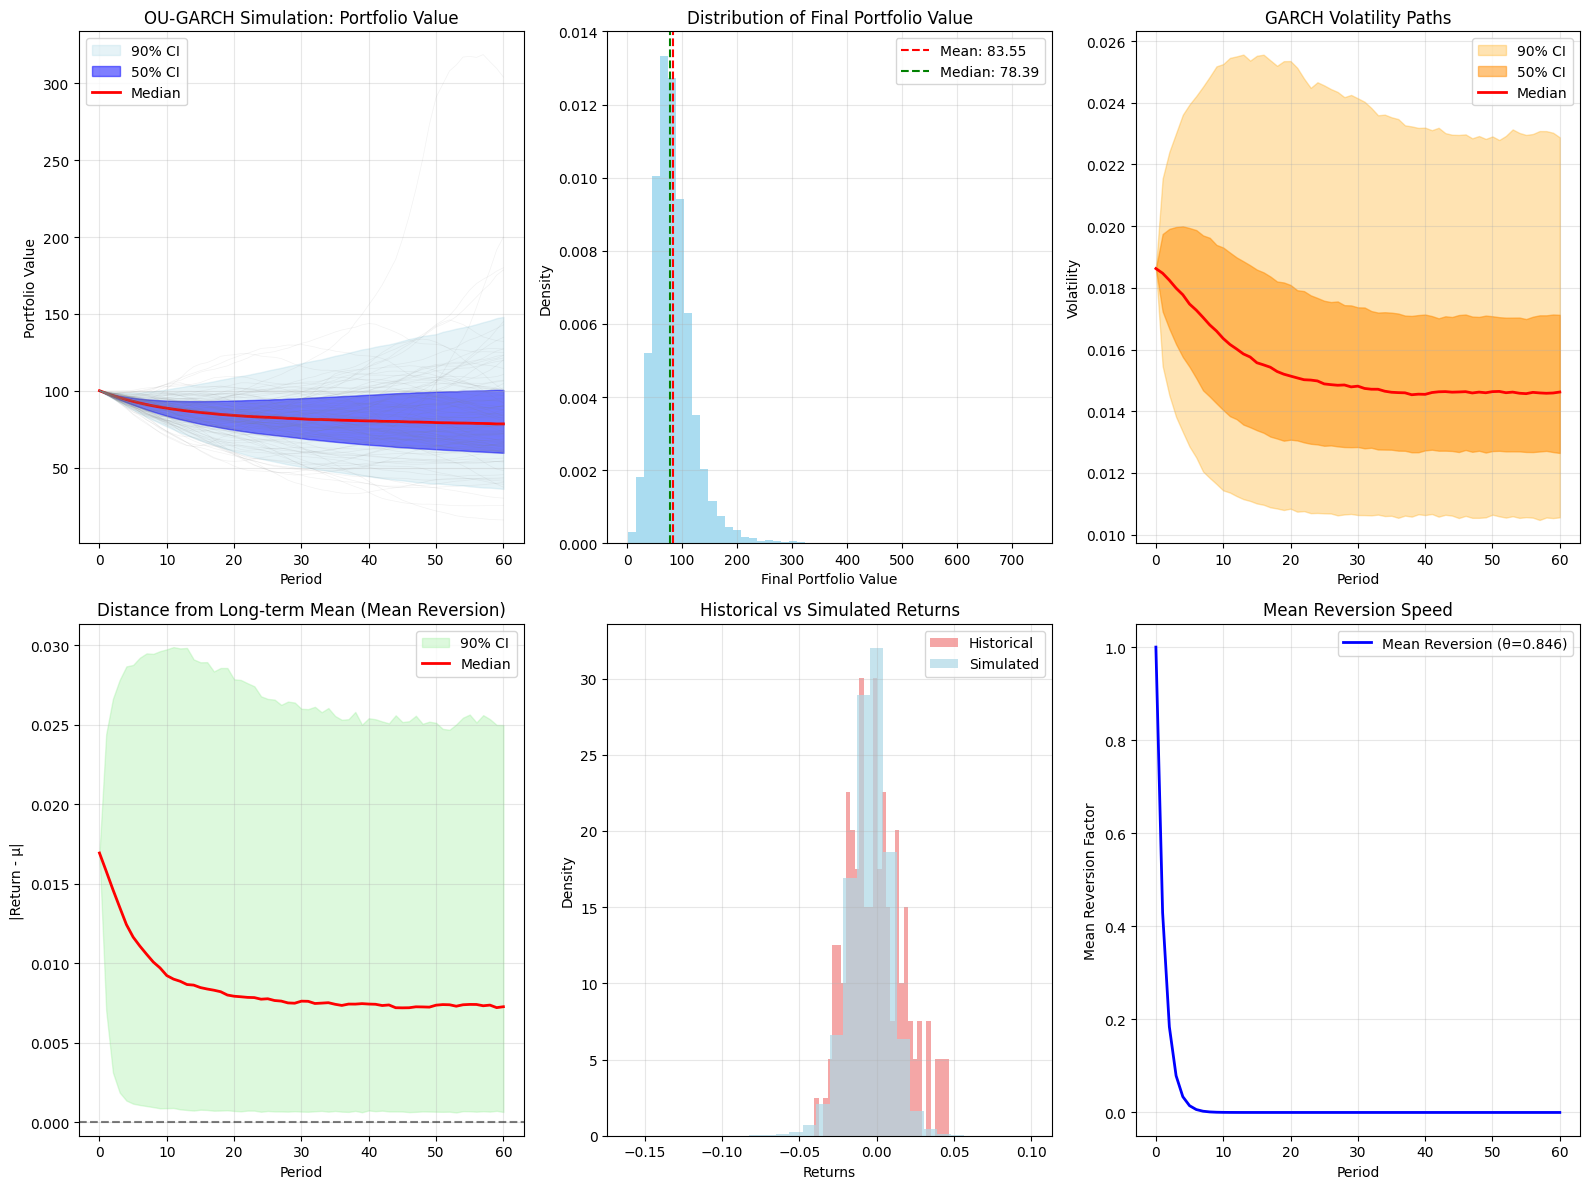

In [2]:
post_2007_returns = hml_returns[hml_returns.index >= '2007-01-01']
mc_sim = HMLMonteCarloOUGARCH(post_2007_returns)

# Estimate OU parameters
theta, mu = mc_sim.estimate_ou_parameters()
print(f"\nOrnstein-Uhlenbeck Parameters:")
print(f"Mean Reversion Speed (θ): {theta:.4f}")
print(f"Long-term Mean (μ): {mu:.4f}")
print(f"Half-life: {np.log(2)/theta:.2f} periods")

# Estimate GARCH parameters
garch_params = mc_sim.estimate_garch_parameters()
print(f"\nGARCH(1,1) Parameters:")
print(f"ω (omega): {garch_params['omega']:.6f}")
print(f"α (alpha): {garch_params['alpha']:.4f}")
print(f"β (beta): {garch_params['beta']:.4f}")
print(f"Persistence (α+β): {garch_params['alpha'] + garch_params['beta']:.4f}")

# Run simulation
print(f"\nRunning OU-GARCH Monte Carlo simulation...")
paths, vol_paths = mc_sim.simulate_ou_garch_paths(n_simulations=10000, n_periods=60, seed=42)

# Get confidence intervals
ci_df = mc_sim.get_confidence_intervals()
print(f"\nConfidence Intervals for Final Period (Portfolio Value):")
print(ci_df.iloc[-1])

# Get summary statistics
summary_stats = mc_sim.get_summary_statistics()
print(f"\nSummary Statistics for Final Values:")
for key, value in summary_stats.items():
    if 'prob' in key:
        print(f"{key}: {value:.2%}")
    else:
        print(f"{key}: {value:.4f}")

# Plot results
mc_sim.plot_simulation_results()